# Neural Network from scratch to classify numbers

The following jupyter notebook demonstrates a single hidden layer neural network built using only NumPy, and trained to classify numbers between 0 - 9. The MNIST dataset was used for this task.

## Loading Datasets

In [725]:
import kagglehub
import os
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Download latest version
dataset_path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", dataset_path)

Path to dataset files: /Users/alexouyang/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [726]:
files = os.listdir(dataset_path)
print("Files:", files)

Files: ['t10k-images-idx3-ubyte', 'train-labels.idx1-ubyte', 'train-images.idx3-ubyte', 't10k-labels-idx1-ubyte', 'train-images-idx3-ubyte', 't10k-labels.idx1-ubyte', 't10k-images.idx3-ubyte', 'train-labels-idx1-ubyte']


In [727]:
training_imgs = idx2numpy.convert_from_file(os.path.join(dataset_path, "train-images.idx3-ubyte"))
raw_training_labels = idx2numpy.convert_from_file(os.path.join(dataset_path, "train-labels.idx1-ubyte"))

In [728]:
training_imgs.shape

(60000, 28, 28)

In [729]:
np.unique(raw_training_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [730]:
raw_training_labels[0]

np.uint8(5)

In [731]:
def format_labels(labels):
    """Converts an array of integer labels into a more suitable format for neural networks.

    Args:
        labels (np.ndarray): The labels of the training/testing set. Shape = (n_samples, ).

    Returns:
        np.ndarray: The labels of the training/testing set formatted as one-hot encoded vectors. Shape = (n_samples, 10).
    """
    res = np.zeros((len(labels), 10), dtype=float)
    res[np.arange(len(labels)), labels] = 1.0
    return res 

def format_inputs(inputs):
    """Converts an array of inputs into a more suitable format for neural networks.

    Args:
        inputs (np.ndarray): The inputs of the training/testing set. Shape = (n_samples, n_rows, n_cols).

    Returns:
        np.ndarray: The inputs of the training/testing set formatted as 1D vectors. Shape = (n_samples, n_rows * n_cols).
    """
    res = inputs.reshape((inputs.shape[0], inputs.shape[1] * inputs.shape[2])).copy()
    return res


In [732]:
training_labels = format_labels(raw_training_labels)
training_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], shape=(60000, 10))

In [733]:
training_inputs = format_inputs(training_imgs)
training_inputs.shape

(60000, 784)

## Function Definitions

In [734]:
def relu(x: np.ndarray) -> np.ndarray:
    """The ReLU function.

    Args:
        x (np.ndarray): The inputs to the ReLU function.

    Returns:
        np.ndarray: The maximum of 0 and each input. Shape = (len(x), )
    """
    return np.maximum(0, x)

def relu_derivative(x: np.ndarray) -> np.ndarray:
    """The ReLU derivative.

    Args:
        x (np.ndarray): The input to the ReLU derivative.

    Returns:
        np.ndarray: One if x > 0, otherwise zero. Shape = (len(x), )
    """
    return (x > 0).astype(float)

def softmax(z: np.ndarray) -> np.ndarray:
    """The softmax function.

    Args:
        z (np.ndarray): The input to the softmax function.

    Returns:
        np.ndarray: Normalisation of inputs to a probability distribution. Shape = (len(z), )
    """
    m = np.max(z)
    return np.exp(z - m) / np.sum(np.exp(z - m))
    
def init_weights(n: int, m: int) -> np.ndarray:
    """Weight initialisation using He initialisation.

    Args:
        n (int): Size of origin layer.
        m (int): Size of destination layer.

    Returns:
        np.ndarray: The weights from the origin to destination layer. Shape = (n, m)
    """
    return np.random.normal(0, np.sqrt(2 / n), (n, m))

def forward_pass(w1: np.ndarray, w2: np.ndarray, x: np.ndarray, b1: np.ndarray, b2: np.ndarray) -> tuple:
    """Forward pass of backpropagation.

    Args:
        w1 (np.ndarray): Weights of the input layer. Shape = (n_inputs, n_hidden).
        w2 (np.ndarray): Weights of the hidden layer. Shape = (n_hidden, n_outputs).
        x (np.ndarray): Inputs to the neural network. Shape = (n_inputs, )
        b1 (np.ndarray): Bias of the input layer.
        b2 (np.ndarray): Bias of the hidden layer.

    Returns:
        tuple: 
            z1 (np.ndarray): Weighted sum of the hidden layer.
            z2 (np.ndarray): Weighted sum of the output layer.
            a1 (np.ndarray): Inputs to the output layer.
            a2 (np.ndarray): Outputs of the output layer.
    """
    z1 = (x @ w1) + b1
    a1 = relu(z1)
    z2 = (a1 @ w2) + b2
    a2 = softmax(z2)
    
    return z1, z2, a1, a2
    
def backward_pass(x: np.ndarray, y: np.ndarray, a1: np.ndarray, a2: np.ndarray, z1: np.ndarray, w1: np.ndarray, w2: np.ndarray, b1: np.ndarray, b2: np.ndarray, lr: float) -> tuple:
    """Backward pass of backpropagation.

    Args:
        x (np.ndarray): Inputs of the training set. Shape = (n_inputs, ).
        y (np.ndarray): Labels of the training. Shape = (n_outputs, ).
        a1 (np.ndarray): Inputs to the output layer. Shape = (n_hidden).
        a2 (np.ndarray): Outputs of the output layer. Shape = (n_outputs, ).
        z1 (np.ndarray): Weighted sum of the hidden layer. Shape = (n_hidden, ).
        w1 (np.ndarray): Weights from the input to hidden layer. Shape = (n_inputs, n_hidden).
        w2 (np.ndarray): Weights from the hidden to output layer. Shape = (n_hidden, n_output).
        b1 (np.ndarray): Bias of the weighted sum at the hidden layer. Shape = (n_hidden, ).
        b2 (np.ndarray): Bias of the weighted sum at the output layer. Shape = (n_output, ).
        lr (float): The learning rate.

    Returns:
        float:
            w1 (np.ndarray): New weights from input to hidden layer. Shape = (n_inputs, n_hidden).
            w2 (np.ndarray): New weights from hidden to output layer. Shape = (n_hidden, n_output).
            b1 (np.ndarray): Biases of weighted sum at hidden layer. Shape = (n_hidden, ).
            b2 (np.ndarray): Biases of weighted sum at output layer. Shape = (n_output, ).
    """
    delta2 = a2 - y 
    delta1 = relu_derivative(z1) * (w2 @ delta2)
    
    w2 -= (lr * np.outer(a1, delta2))
    w1 -= (lr * np.outer(x, delta1))
    
    b2 -= lr * delta2
    b1 -= lr * delta1
    
    return w1, w2, b1, b2

def backprop(x: np.ndarray, y: np.ndarray, w1: np.ndarray, w2: np.ndarray, b1: np.ndarray, b2: np.ndarray, lr: float) -> tuple:
    """Backpropagatio algorithm.

    Args:
        x (np.ndarray): Inputs to the neural network. Shape = (n_inputs, )
        y (np.ndarray): Labels of the neural network. Shape = (n_outpus, )
        w1 (np.ndarray): Weights from the input to hidden layer. Shape = (n_inputs, n_hidden)
        w2 (np.ndarray): Weights from the hidden to output layer. Shape = (n_hidden, n_output)
        b1 (np.ndarray): Biases of the weighted sums in the hidden layer. Shape = (n_hidden, )
        b2 (np.ndarray): Biases of the weighted sums in the output layer. Shape = (n_output, )
        lr (float): The learning rate.

    Returns:
        tuple: 
            w1 (np.ndarray): Updated weights from the input to hidden layer. Shape = (n_inputs, n_hidden)
            w2 (np.ndarray): Updated weights from the hidden to output layer. Shape = (n_hidden, n_output)
            b1 (np.ndarray): Biases of the weighted sums in the hidden layer. Shape = (n_hidden, )
            b2 (np.ndarray): Biases of the weighted sums in the output layer. Shape = (n_output, )
    """
    z1, z2, a1, a2 = forward_pass(w1, w2, x, b1, b2)
    w1, w2, b1, b2 = backward_pass(x, y, a1, a2, z1, w1, w2, b1, b2, lr)
    return w1, w2, b1, b2

def train_nn(x: np.ndarray, y: np.ndarray, w1: np.ndarray, w2: np.ndarray, b1: np.ndarray, b2:np.ndarray, lr: float, epochs=1) -> tuple:
    """Train a neural network. 

    Args:
        x (np.ndarray): Inputs to the neural network. Shape = (n_inputs, ).
        y (np.ndarray): Labels of the neural network. Shape = (n_outpus, )
        w1 (np.ndarray): Weights from the input to hidden layer. Shape = (n_inputs, n_hidden). 
        w2 (np.ndarray): Weights from the hidden to output layer. Shape = (n_hidden, n_output)
        b1 (np.ndarray): Biases of the weighted sums in the hidden layer. Shape = (n_hidden, )
        b2 (np.ndarray): Biases of the weighted sums in the output layer. Shape = (n_output, )
        lr (float): The learning rate.
        epochs (int, optional): Number of epochs to train for. Defaults to 1.

    Returns:
        tuple:
            w1 (np.ndarray): Updated weights from the input to hidden layer. Shape = (n_inputs, n_hidden)
            w2 (np.ndarray): Updated weights from the hidden to output layer. Shape = (n_hidden, n_output)
            b1 (np.ndarray): Biases of the weighted sums in the hidden layer. Shape = (n_hidden, )
            b2 (np.ndarray): Biases of the weighted sums in the output layer. Shape = (n_output, )
    """
    n = len(x)
    indices = np.arange(n)
    for _ in range(epochs):
        np.random.shuffle(indices)
        x_train, y_train = x[indices], y[indices]
        for i in range(n):
            w1, w2, b1, b2 = backprop(x_train[i], y_train[i], w1, w2, b1, b2, lr)
    return w1, w2, b1, b2


### Hyperparameters

In [ ]:
n1 = training_inputs.shape[1]
n2 = (n1 + 10) // 2

w1 = init_weights(n1, n2)
w2 = init_weights(n2, 10)

b1 = np.zeros((n2, ), dtype=float)
b2 = np.zeros((10, ), dtype=float)

lr = 0.0001
epochs = 1

## Training

In [736]:
trained_w1, trained_w2, trained_b1, trained_b2 = train_nn(training_inputs, training_labels, w1, w2, b1, b2, lr, epochs)

## Testing

In [737]:
testing_imgs = idx2numpy.convert_from_file(os.path.join(dataset_path, "t10k-images.idx3-ubyte"))
raw_testing_labels = idx2numpy.convert_from_file(os.path.join(dataset_path, "t10k-labels.idx1-ubyte"))

In [738]:
testing_labels = format_labels(raw_testing_labels)

In [739]:
testing_labels[0].shape

(10,)

In [740]:
testing_inputs = format_inputs(testing_imgs)

In [756]:
def predict(x: np.ndarray, w1: np.ndarray, w2: np.ndarray, b1:np.ndarray, b2:np.ndarray) -> np.ndarray:
    """Predict a number.

    Args:
        x (np.ndarray): A single input to the neural network. Shape = (784, )
        w1 (np.ndarray): Weights from the input to hidden layer. Shape = (n_inputs, n_hidden). 
        w2 (np.ndarray): Weights from the hidden to output layer. Shape = (n_hidden, n_output). 
        b1 (np.ndarray): Biases of the weighted sums in the hidden layer. Shape = (n_hidden, )
        b2 (np.ndarray): Biases of the weighted sums in the output layer. Shape = (n_output, )

    Returns:
        np.ndarray: Probability distribution of the outputs.
    """
    z1 = (x @ w1) + b1
    a1 = relu(z1)
    z2 = (a1 @ w2) + b2
    a2 = softmax(z2)
    return a2
    
def validate_nn(x: np.ndarray, y: np.ndarray, w1: np.ndarray, w2: np.ndarray, b1: np.ndarray, b2: np.ndarray) -> float:
    """ Testing o
    Args:
        x (np.ndarray): Inputs to the neural network. Shape = (n_inputs, ).
        y (np.ndarray): Labels of the neural network. Shape = (n_outpus, ). 
        w1 (np.ndarray): Weights from the input to hidden layer. Shape = (n_inputs, n_hidden). 
        w2 (np.ndarray): Weights from the hidden to output layer. Shape = (n_hidden, n_output). 
        b1 (np.ndarray): Biases of the weighted sums in the hidden layer. Shape = (n_hidden, )
        b2 (np.ndarray): Biases of the weighted sums in the output layer. Shape = (n_output, )
    Returns:
        float: Accuracy of the neural network on the test set.
    """
    n = len(x)
    accuracy = 0
    for i in range(n):
        a2 = predict(x[i], w1, w2, b1, b2 )
        if np.argmax(a2) == np.argmax(y[i]):
            accuracy += 1
    return accuracy / n

def visualise_prediction(index: int, inputs: np.ndarray, labels: np.ndarray) -> None:
    """Visualise a prediction for a given input.

    Args:
        index (int): The index of the input and label pair to visualise.
        inputs (np.ndarray): The input array (Can be training or testing set). Must be the same set as labels.
        labels (np.ndarray): The label array (Can be training or testing set). Must be the same set as input.
    """
    image = inputs[index]
    label = labels[index]
    
    formatted_input = image.reshape(image.shape[0] * image.shape[1]).copy()
    
    prediction = predict(formatted_input, trained_w1, trained_w2, trained_b1, trained_b2)
    print("Prediction: ", np.argmax(prediction))
    print("Actual: ", label)
    
    plt.gray()
    plt.imshow(image, interpolation='nearest')
    plt.show()

In [748]:
accuracy = validate_nn(testing_inputs, testing_labels, trained_w1, trained_w2, trained_b1, trained_b2)
print("Accuracy: ", accuracy)

Accuracy:  0.9234


Prediction:  5
Actual:  5


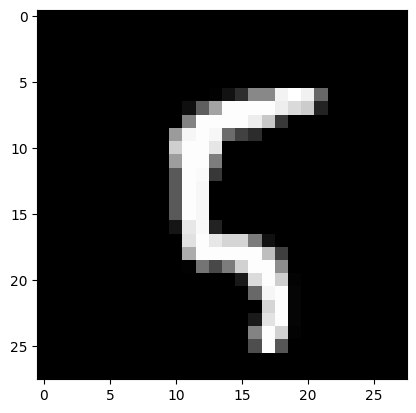

In [760]:
visualise_prediction(100, training_imgs, raw_training_labels)